### Full Multi Grid Solution of the Dilaton Field Equation in Three Dimensions For a Long Rectangular String
##### Vikram Vyas

#### About this notebook
This notebook was used to do the numerical calculations described in the section 4.2 of the accompanying paper "Flux-tubes and their intrinsic shape in confining gauge theories with gravitational dual" Please feel free to use it for any accademic purpose. For any comments or clarification send me an email: vikram@physicsinfield.org

#### How to use this notebook

The notebook requires the python files:

utility_3DimMG.py


#### References

For multigrid algorithm used see:

J. Stewart. Python for Scientists. Cambridge University Press, 2017.

and the python implementation

https://github.com/AbhilashReddyM/GeometricMultigrid


#### Acknowledgments
I would like to thank the world wide community of python developers.


#### Python preliminaries

In [1]:
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for using Cython
%load_ext Cython

# For random numbers
import random

# for time stamp on graphics
import time
seconds = time.time()
local_time = time.ctime(seconds)

#### Utility functions for Multigrid

This module imports functions used in implementing multigrid algorithm

In [2]:
from utility_3DimMG import L2_norm, prolong_lin, restric, restrict_hw

#### Cython implementation of the relaxation algorithm

In [3]:
%%cython
cimport numpy as np
cimport cython
@cython.boundscheck(False) # turn of bounds-checking for entire function
@cython.wraparound(False)
@cython.cdivision(True)

cdef A(float a, float nz):
    return (1.0/( a * nz))**3


cdef B(float sigma, float a, float nz):
    return sigma**2 * ((1.0 /(a * nz))**3 - a * nz)


cdef C(float sigma, float a, float nz):
    return 4*A(a, nz+0.5)+B(sigma, a, nz-0.5)+B(sigma, a, nz+0.5)


# solving L(error) = errorCentre - errorB - errorZ = source
def updateError(float sigma, int Nz, int Nx1, int Nx2,  
                np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,  
                np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] source):
    
        cdef int nz, nx1, nx2
        cdef float a, D, deltaPhiB, deltaPhiZ, newPhi
        
        # lattice constant in the units of z_0
        a = 1.0/(Nz-1)
        
        for nz in range(1, Nz - 1):
            for nx1 in range(1, Nx1 - 1):
                for nx2 in range(1, Nx2 - 1):
                    if nz == Nz-2:
                        phi[Nz - 1, nx1, nx2] = phi[Nz - 2, nx1, nx2] # Neumann B.C. at z = Nz
                    deltaPhiB = A(a, nz + 0.5) * (phi[nz, nx1+1, nx2]+phi[nz, nx1-1, nx2]+phi[nz, nx1, nx2+1]+phi[nz, nx1, nx2-1])
                    deltaPhiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1, nx2] + B(sigma, a, nz-0.5)*phi[nz-1, nx1, nx2]
                    newPhi = (1.0/C(sigma, a, nz)) * (deltaPhiB + deltaPhiZ + source[nz, nx1, nx2])
                    phi[nz, nx1, nx2] = newPhi

def relaxError(float sigma, int Nz, int Nx1, int Nx2,  
               np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,  
               np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] source, int nit = 1):
    cdef int ii
    for ii in range(nit):
        updateError(sigma, Nz, Nx1, Nx2, phi, source)
    return phi

def residue(float sigma, int Nz, int Nx1, int Nx2, 
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] phi,
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] jSource, 
            np.ndarray[np.float_t, ndim = 3, negative_indices = False,  mode = 'c'] residue):
    
    # L(phi) = phiCentre - phiB - phiZ = jSource
    # res = jSource - L(phi)
 
    # lattice constant in the units of z_0 = 1
    a = 1.0/(Nz - 1.0)
    
    #residue = np.zeros((Nz, Nx1, Nx2), float)
    for nz in range(1, Nz - 1):
        for nx1 in range(1, Nx1 - 1):
            for nx2 in range(1, Nx2 - 1):
                if nz == Nz-2:
                        phi[Nz - 1, nx1, nx2] = phi[Nz - 2, nx1, nx2] # Neumann B.C. at z = Nz
                phiCentre = C(sigma, a, nz) * phi[nz, nx1, nx2]
                phiB = A(a, nz + 0.5) * (phi[nz, nx1+1, nx2]+phi[nz, nx1-1, nx2]+phi[nz, nx1, nx2+1]+phi[nz, nx1, nx2-1])
                phiZ = B(sigma, a, nz + 0.5) * phi[nz+1, nx1, nx2] + B(sigma, a, nz-0.5)*phi[nz-1, nx1, nx2]
                residue[nz, nx1, nx2] = jSource[nz, nx1, nx2] + (phiB + phiZ - phiCentre)
    return residue

#### Multigrid

In [4]:
def V_cycle(sigma, nz, nx1, nx2, num_levels, phi, source, level=1):
    
    # solve exactly at the bottom layer - recursion ends here
    if (level==num_levels):
        phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=100)
        return phi
    
    #Step 1: Relax L(phi) = source on this grid and calculate the residue
    phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=75)
    res = np.zeros_like(phi)
    res = residue(sigma, nz, nx1, nx2, phi, source, res)
    
    
    #Step 2: Restrict residual to coarse grid
    res_c = restrict_hw(res)
    
    #Step 3:Solve Le_c=res_c on the coarse grids recursively
    coarseGridShape = np.shape(res_c)
    NzC, Nx1C, Nx2C = coarseGridShape[0], coarseGridShape[1], coarseGridShape[2]
    err_c = np.zeros_like(res_c)
    err_c = V_cycle(sigma, NzC, Nx1C, Nx2C, num_levels, err_c, res_c, level+1)
    
    
    #Step 4: Interpolate(prolong) e_c to fine grid and add to phi
    phi = phi + prolong_lin(err_c)
    
    #Step 5: Relax L(phi) = source on this grid 
    phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=75)
    
    return phi

In [5]:
def FMG(sigma, nz, nx1, nx2, num_levels, source, nv=1, level=1):
    # solve exactly at the bottom layer 
    
    if (level==num_levels):
        phi = np.zeros_like(source)
        phi = relaxError(sigma, nz, nx1, nx2, phi, source, nit=100)
        print("solved the bottom grid")
        return phi
    
    #Step 1: Restrict the rhs to a coarse grid
    source_c = restrict_hw(source)
    
    #Step 2: Solve the coarse grid problem using FMG
    coarseGridShape = np.shape(source_c)
    NzC, Nx1C, Nx2C = coarseGridShape[0], coarseGridShape[1], coarseGridShape[2]
    current_level = level + 1
    phi_c = FMG(sigma, NzC, Nx1C, Nx2C, num_levels, source_c, nv, current_level)
    
    #Step 3: Interpolate phi_c to the fine grid
    phi = prolong_lin(phi_c)
    
    
    #step 4: Execute 'nv' V-cycles
    for _ in range(nv):
        phi = V_cycle(sigma, nz, nx1, nx2, num_levels-level, phi, source)
    print("finished V-cycles for level = ", num_levels-level)
    return phi

### Geometry of the fine lattice
Length along the radial direction in the units of lattice constants $a$. Lattice constant along $X_1$ and $X_2$ is $b =\sigma a$

In [6]:
num_levels = 6
Lz = Lx1 = Lx2  = 2**(num_levels + 1)
a = 1.0/Lz
sigma = 20.0
b = a * sigma
print("L = ", Lz, "a = ", a ,"b = sigma * a = ",  b)

L =  128 a =  0.0078125 b = sigma * a =  0.15625


For each direction, the number of points is one more than the length

In [7]:
Nz = Lz + 1
Nx1 = Lx1 + 1
Nx2 = Lx2 + 1
#print(Lz, Nz)

### Dilaton field
Initially set to zero. This also implements the homogenous Dirichlet boundary conditions
we will implement Neumann BC on $z = L_z$ plane in the relaxation algorithm.

In [8]:
Phi = np.zeros((Nz,Nx1,Nx2), float)                                    

### Source function for a very long open string
We will approximate the open string connecting a quark and an antiquark when $L_{q\bar{q}}>> z_0$ by a rectangular string

In [9]:
NzM = Lz - 64 # rect string is one lattice constant below the horizon
g = -10 # negative sign is to incorporate L(phi) = - stringSource

In [10]:
stringShape = np.zeros((Nz, Nx1, Nx2), float) # empty array to hold the string shape
StringSource = np.zeros((Nz, Nx1, Nx2), float) # empty array to hold the source array

Lboundary = sigma # length of the boundary region in units of z0
X1quark =  2.0 #  position of the quark in the units of z0
X1qbar = Lboundary - X1quark
Lqqbar = Lboundary - 2.0 * X1quark

Nx1quark = int(X1quark/b)
Nx1qbar = int(X1qbar/b)

print("X1quark = ", X1quark, "  Nx1quark = ", Nx1quark, " X1qbar = ", X1qbar, "  Nx1qbar = ", Nx1qbar)
print("Lqqbar = ", Lqqbar)

X1quark =  2.0   Nx1quark =  12  X1qbar =  18.0   Nx1qbar =  115
Lqqbar =  16.0


In [11]:
Nx2Centre = int(Nx2/2.0)
NzTop = NzM

# Left  and right leg string is parametrized by z coordinate
for iz in range(1, NzTop):
    
    # square root of the induced determinant
    zString = iz * a
    fzSqrt = (1-zString**4)**(0.5)
    gSqrt = 1.0 / (zString**2 * fzSqrt)
    
    srsLeg = g * sigma * gSqrt
    # Left leg
    stringShape[iz, Nx1quark, Nx2Centre] = 1.0
    StringSource[iz, Nx1quark, Nx2Centre] = srsLeg * stringShape[iz, Nx1quark, Nx2Centre]
    
    # Right leg
    stringShape[iz, Nx1qbar, Nx2Centre] = 1.0
    StringSource[iz, Nx1qbar, Nx2Centre] = srsLeg * stringShape[iz, Nx1qbar, Nx2Centre]
    
# Top string is parametrized by x_1 coordinate

for ix in range(Nx1quark, Nx1qbar+1):

    NzC = NzTop
    zTop = NzC * a
    #square root of det
    gSqrt = 1.0/(zTop**2)
    
    srsTop = g * sigma * gSqrt
    
    stringShape[NzC, ix, Nx2Centre] = 1.0
    StringSource[NzC, ix, Nx2Centre] = srsTop * stringShape[NzC, ix, Nx2Centre]

z, x, y = stringShape.nonzero()
%matplotlib auto
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# remove the tick marks
ax.grid(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)


ax.scatter(x, y, z, zdir='z', c= 'red')
#ax.plot(x,y,z, zdir='z', c='red')
#ax.plot(x,y,z)
#plt.show()
#plt.savefig("Rectangular String")

### Solving using FMG

In [12]:
%%time
Phi = FMG(sigma, Nz, Nx1, Nx2, num_levels, StringSource, nv = 20 , level = 1 )

solved the bottom grid
finished V-cycles for level =  1
finished V-cycles for level =  2
finished V-cycles for level =  3
finished V-cycles for level =  4
finished V-cycles for level =  5
CPU times: user 26min 59s, sys: 2.26 s, total: 27min 1s
Wall time: 26min 12s


In [13]:
res = np.zeros_like(Phi)
res = residue(sigma, Nz, Nx1, Nx2, Phi, StringSource, res)
resL2Norm = L2_norm(res, a)
print("Final residue = ", round(resL2Norm, 3))

Final residue =  0.0


In [14]:
colorinterpolation = 50
colourMap = plt.cm.jet 
X1, Z = np.meshgrid(np.arange(0, Nz), np.arange(0, Nx1))

In [15]:
nx2C = int(Nx2/2)
dilatonInStringPlane = Phi[:, :, nx2C]

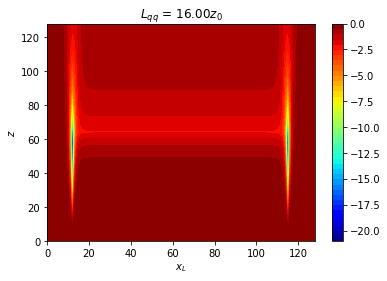

<Figure size 432x288 with 0 Axes>

In [16]:
plt.contourf(Z, X1, dilatonInStringPlane.T, colorinterpolation, cmap=colourMap)
plt.colorbar()
label = "$L_{qq}$ = %4.2f$z_0$" % (Lqqbar)
plt.title(label)
plt.xlabel("$x_L$")
plt.ylabel("$z$")
# remove the tick marks
#ax3 = plt.axes()
#plt.setp(ax3.get_xticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)
#ax3.tick_params(axis='both', which='both', length=0)
figCaption = "Dilaton_Field" + str(Lqqbar)+".png"
plt.savefig(figCaption)
plt.show()
plt.clf()

### Calculating $z_0^4<\Omega|{\widehat{\mathcal{O}}_{F^{2}}}\left(x_1, x_2 \right)|\Omega>_{q\bar{q}}$

In [17]:
def B(a, nz):
    return (1.0 /(a * nz))**3 - a * nz
Ez = - (B(a, 0.5)/a) * Phi[1, :, :]

### Ploting the thickness in the central plane

Max Transverse Field =  66.62808225987757 Ez Cutoff =  66.62808225987757
Half Width in the central plane in the units of $z_0$ =  0.33


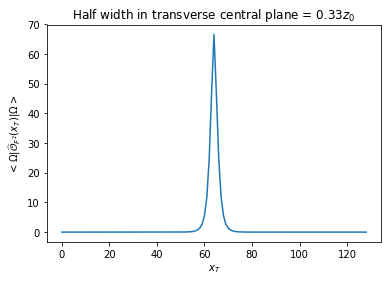

66.6


In [18]:
nx1c = int(Nx1/2)
EzT =  - (B(a, 0.5)/a) * Phi[1, nx1c, :]
xTrange = np.arange(Nx2)
#
# rescale to delinate
EzCutoff =  EzT.max() #23.3
EzT[EzT > EzCutoff] = EzCutoff
print("Max Transverse Field = ", EzT.max(), "Ez Cutoff = ", EzCutoff)
#
centre = np.sum(xTrange * EzT)/np.sum(EzT)
widthCoord = np.sqrt(np.abs(np.sum((xTrange-centre)**2*EzT)/np.sum(EzT)))
#print("Width in the central plane = ", widthCoord)
physicalWidth = round(widthCoord * sigma * a, 2)
print("Half Width in the central plane in the units of $z_0$ = ", physicalWidth)
#
label = "Half width in transverse central plane = %4.2f$z_0$" % (physicalWidth)
plt.title(label)
plt.xlabel("$x_T$")
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>$")
plt.plot(xTrange, EzT)
figCaption = "Half width in Central Plane" + str(Lqqbar)+ str(NzM) + local_time + ".png"
plt.savefig(figCaption)
plt.show()
EzTmax = np.max(EzT)
print(round(np.max(EzT), 1))

#### Width in the plane containing the quark

Half Width in the quark plane in the units of $z_0$ =  0.46


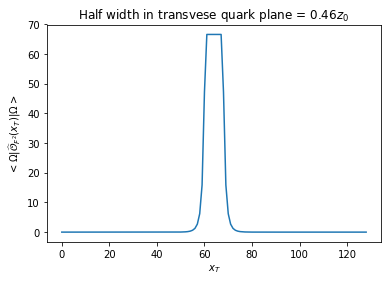

In [19]:
# Flux in the transverse plane containg the quark
EzQ =  - (B(a, 0.5)/a) * Phi[1, Nx1quark, :]
# rescale to delinate
#EzCutoff = 23.3
EzQ[EzQ > EzCutoff] = EzCutoff
# Width of cutoff distribution
#
centre = np.sum(xTrange * EzQ)/np.sum(EzQ)
widthCoord = np.sqrt(np.abs(np.sum((xTrange-centre)**2*EzQ)/np.sum(EzQ)))

physicalWidthInQuarkPlane = round(widthCoord * sigma * a, 2)
print("Half Width in the quark plane in the units of $z_0$ = ", physicalWidthInQuarkPlane)
#
# Labels
label = "Half width in transvese quark plane = %4.2f$z_0$ " % (physicalWidthInQuarkPlane)

plt.title(label)
plt.xlabel("$x_T$")
plt.ylabel("$<\Omega|{\widehat{\mathcal{O}}_{F^{2}}(x_T)}|\Omega>$")
# Caption
figCaption = "Half width in the Quark Plane" + str(Lqqbar) + str(NzM) + local_time + ".png"

#
plt.plot(xTrange, EzQ)
plt.savefig(figCaption)
plt.show()

### Plotting the flux-tube

In [20]:
X1, X2 = np.meshgrid(np.arange(0, Nx1), np.arange(0, Nx2))

In [21]:
EzR = Ez

In [22]:
#EzCutoff = 23.3 # 1.0 * EzTmax
EzR[EzR > EzCutoff] = EzCutoff

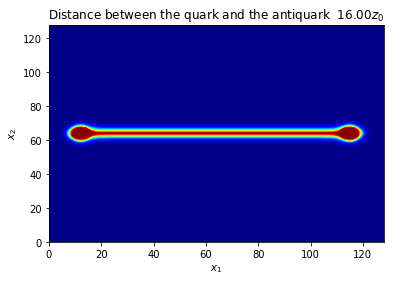

<Figure size 432x288 with 0 Axes>

In [23]:
plt.contourf(X1, X2, EzR.T, colorinterpolation, cmap=colourMap)

# Set Colorbar
#plt.colorbar()

# Show the result in the plot window
figLegend = "Fluxtube " + "Lqqbar = " + str(Lqqbar) + "Lz = " + str(Lz) + "simga = " + str(sigma) + str(NzM) + local_time + ".png"
label = "Normalized flux distribution. $L_{qq}$ = %4.2f$z_0$" % (Lqqbar)
# Create Figure and Axes instances 
label = "Distance between the quark and the antiquark  %4.2f$z_0$" % (Lqqbar)
plt.title(label)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#ax.set_yticklabels([])
#ax.set_xticklabels([])
plt.savefig(figLegend)
plt.show()
plt.clf()

In [24]:
z, x, y = stringShape.nonzero()
%matplotlib auto
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, zdir='z', c= 'red')
#ax.plot(x. y, z, zdir='z', c = 'red')
cset = ax.contourf(X1, X2, EzR.T, zdir='z', offset = 0, origin = 'image', cmap=colourMap)
ax.set_xlim(0,Nx1)
ax.set_ylim(0, Nx2)
plt.axis('off')

plt.xlabel("$x_L$")
plt.ylabel("$x_T$")

ax.grid(False)

# remove the tick marks
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)
fig.colorbar(cset, shrink = 0.5, aspect = 5)

#Caption
label = "Distance between the quark and the antiquark  %4.2f$z_0$" % (Lqqbar)
#label = "Open string flux-tube duality"
#plt.title(label)

figLegend = "LzM = " + str((NzM +1) * a) + "Lz = " + str(Lz) + "simga = " + str(sigma)
print(figLegend)
plt.show()
figTitle =  "openString "+ "Lqqbar = " + str(Lqqbar) + "simga = " + str(sigma) + str(NzM) + local_time  + ".png"
plt.savefig(figTitle)

Using matplotlib backend: Qt5Agg
LzM = 0.5078125Lz = 128simga = 20.0
